In [11]:
%matplotlib inline
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import numpy as np
import matplotlib.pyplot as plt
import glob
from focal import Focal, focal_to_spike, spike_trains_to_images_g
from scipy.signal import convolve2d

def todict(np_file):
    d = {}
    for k in list(np_file.keys()):
        try:
            d[k] = np_file[k].item()
        except:
            d[k] = np_file[k]
    return d

def ssa_to_img(ssa, scale, img_shape, power_exp=-1.0, start_time=0.0, end_time=np.inf):
    max_places = 4 * np.prod(img_shape)
    max_t = np.max([np.max(ts) for ts in ssa if len(ts)])
    t2p = max_places / max_t
    h, w = img_shape
    n_per_scale = h * w
    start = scale * n_per_scale
    end = start + n_per_scale
    img = np.zeros(img_shape)
    for pix, neuron in enumerate(range(start, end)):
        times = np.asarray(ssa[neuron])
        whr = np.where(np.logical_and(start_time <= times, times < end_time))[0]
        n_spikes = len(whr)
        if n_spikes > 0:
            places = (times[whr] * t2p) + 1
            img[pix//w, pix%w] = np.sum(places**(power_exp))

    
    return img
        

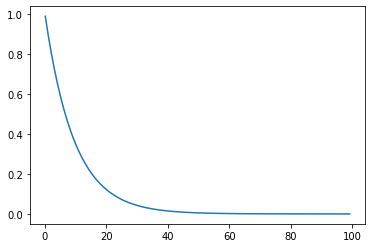

In [12]:
x = np.arange(0.1, 100)
y = (0.9)**(x)
plt.figure()
plt.plot(x, y)
plt.show()

Loaded correlations from file
range(0, 3)
range(0, 11)
range(0, 21)
range(0, 45)


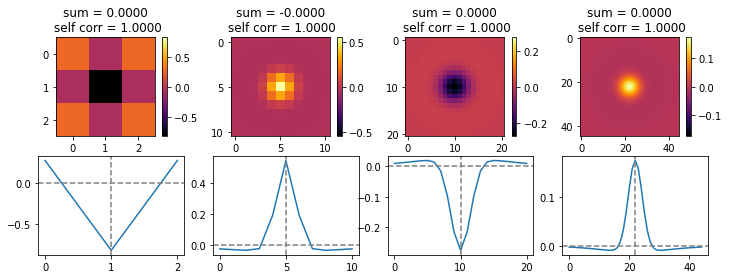

In [55]:
fcl = Focal(small_image=True)
kernels = fcl.kernels.full_kernels
fig = plt.figure(figsize=(12, 4))
for k in kernels:
    ax = plt.subplot(2, 4, k+1)
    ax.set_title("sum = {:.4f}\n self corr = {:.4f}".format(np.sum(kernels[k]), np.sum(kernels[k]**2)))
    ki = kernels[k]
    
    vmax = np.max(np.abs(kernels[k]))
    im = plt.imshow(kernels[k], cmap='inferno', vmin=-vmax, vmax=vmax)
    plt.colorbar(im)

    ax = plt.subplot(2, 4, 4+k+1)
#     ax.set_title("{}\n{}".format(np.sum(kernels[k]), np.sum(kernels[k]**2)))
    
    half = kernels[k].shape[0] // 2
    _diag = range(kernels[k].shape[0])
    print(_diag)
    im = plt.plot(kernels[k][_diag, _diag])
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(half, color='gray', linestyle='--')
    

plt.savefig('centre-surround-kernels.png')
plt.show()
    

In [69]:
dir_name = "../output_spikes/train/1"
files = glob.glob(os.path.join(dir_name, '*'))
print(len(files))

183


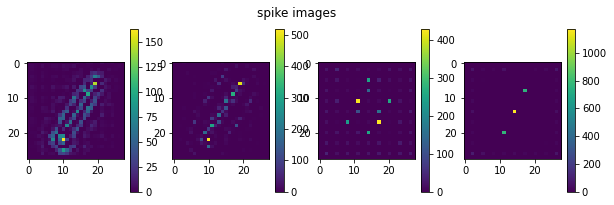

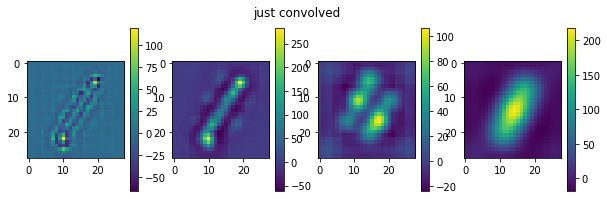

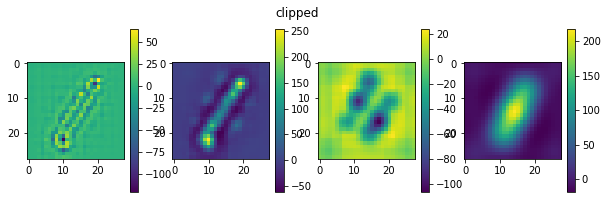

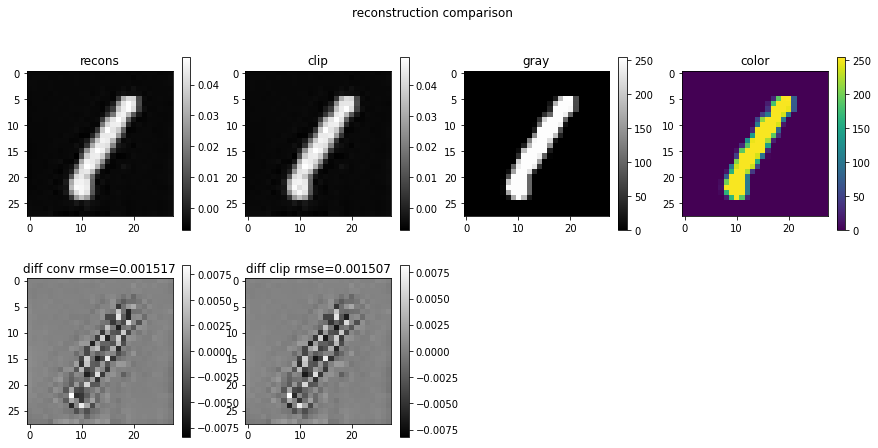

In [70]:
# dir_name = "../mnist_output/train/2"
files = glob.glob(os.path.join(dir_name, '*'))

spikes = []
fw = 3.
for f in files[-1:]:
    data = todict(np.load(f, allow_pickle=True))
    kernels = data['kernels']
    shape = data['grayscale_image'].shape

    spikes[:] = data['focal_spikes']
    images = spike_trains_to_images_g(spikes, data['grayscale_image'])
    fig = plt.figure(figsize=(10, 3))
    plt.suptitle("spike images")
    for i in images:
        k = images[i]
        ax = plt.subplot(1, 4, i+1)
        im = plt.imshow(k)
        plt.colorbar(im)
    
    plt.savefig('spike_images.png')
    
    conv_images = [
        convolve2d(images[k], kernels[k], mode='same')
        for k in images
    ]
    clipped_imgs = []
    
    fig = plt.figure(figsize=(10, 3))
    plt.suptitle("just convolved")
    for i, k in enumerate(conv_images):
        upper = np.inf if i in [1, 3] else 0.0
        lower = 0.0 if i in [1, 3] else -np.inf
#         clipped_imgs.append(np.clip(k, lower, upper))
        clipped_imgs.append(np.clip(k, -255., 255.))

        ax = plt.subplot(1, 4, i+1)
        im = plt.imshow((k if i in [1, 3] else -k))
        plt.colorbar(im)    
    plt.savefig('convolved_images.png')
    
    # 
    
    fig = plt.figure(figsize=(10, 3))
    plt.suptitle('clipped')
    for i, k in enumerate(clipped_imgs):
        ax = plt.subplot(1, 4, i+1)
        im = plt.imshow(k)
        plt.colorbar(im)    
    
    s = np.sum(conv_images, axis=0)
    c = np.sum(clipped_imgs, axis=0)
#     s[:, -1] = 0
#     s[:, 0] = 0
#     s[-1, :] = 0
#     s[0, :] = 0
#     min_s = np.min(s)
#     if min_s < 0:
#         s += np.min(s)
#     s = np.clip(s, 0, 255)
    plt.figure(figsize=(15, 7))
    plt.suptitle('reconstruction comparison')
    ax = plt.subplot(2, 4, 1)
    ax.set_title('recons')
#     im = plt.imshow(np.clip(s, 0, 255), cmap='gray')
    sn = (s - s.mean()) / s.var()
#     sn = (s - s.min())
#     sn *= (255./sn.max())
    im = plt.imshow(sn, cmap='gray')
    plt.colorbar(im)

    ax = plt.subplot(2, 4, 2)
    ax.set_title('clip')
    cn = (c - c.mean()) / c.var()
#     cn = (c - c.min())
#     cn *= (255./cn.max())
    im = plt.imshow(cn, cmap='gray')

#     im = plt.imshow(np.clip(c, 0, 255), cmap='gray')
#     im = plt.imshow(c, cmap='gray')
    plt.colorbar(im)

    
    ax = plt.subplot(2, 4, 3)
    ax.set_title('gray')
    im = plt.imshow(data['grayscale_image'], cmap='gray')
    plt.colorbar(im)

    ax = plt.subplot(2, 4, 4)
    ax.set_title('color')
    im = plt.imshow(data['color_image'].astype('uint8'))
    plt.colorbar(im)

    gray = data['grayscale_image']
    gn = (gray - gray.mean()) / gray.var()
#     gn = gray
    diff = gn - sn
    vmax = np.max(np.abs(diff))
    vmin = -vmax
    rmse = np.sqrt(np.mean(diff**2))
    ax = plt.subplot(2, 4, 5)
    ax.set_title('diff conv rmse={:.6f}'.format(rmse))
    im = plt.imshow(diff, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(im)

    ax = plt.subplot(2, 4, 6)
    diff = gn - cn
    vmax = np.max(np.abs(diff))
    vmin = -vmax
    rmse = np.sqrt(np.mean(diff**2))
    ax.set_title('diff clip rmse={:.6f}'.format(rmse))
    im = plt.imshow(diff, cmap='gray', vmin=vmin, vmax=vmax)
    plt.colorbar(im)

    
    plt.savefig('reconstruction')
    plt.show()
    
